In [1]:
import os
import random
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Helper functions

In [2]:
def get_img(img):
    # For image loading
    # Read img file; Convert BGR -> RGB; Standardise
    img = cv2.imread(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255

def show_img(img):
    # For image visualisation
    # Load to cpu, detach gradient, cast to ndarray and unstandardise
    img = img.to('cpu').detach().numpy() * 255
    img = img.astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

def seed_everything(seed):
    # For reproducibility
    # https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Used to preserve reproducibility in DataLoader
    # https://pytorch.org/docs/stable/notes/randomness.html
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
def train_test_split(fungi_list, 
                     fungi_root='../data/defungi/',
                     train_end=0.65,
                     val_end=0.80):
    for i, c in enumerate(['H1', 'H2', 'H3', 'H5', 'H6']):
        fungi = np.array(fungi_list[i])

        n = len(fungi)
        indices = np.arange(n)
        train_idx = int(n * train_end)
        val_idx = int(n * val_end)

        np.random.shuffle(indices)
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        trainval_indices = indices[:val_idx]
        test_indices = indices[val_idx:]

        train = fungi[train_indices]
        val = fungi[val_indices]
        trainval = fungi[trainval_indices]
        test = fungi[test_indices]

        # This shows that there is no intersection between train and test set
        print(np.intersect1d(train, val),
              np.intersect1d(trainval, test))

        for subset, path in zip([train, val, trainval, test],
                                ['train', 'val', 'trainval', 'test']):
            dst = f'{fungi_root}{path}/{c}/'
            os.makedirs(dst, exist_ok=True)
            for src in subset:
                shutil.copy(src, dst)    
    
        # dst = f'{fungi_root}val/{c}/'
        # os.makedirs(dst, exist_ok=True)
        # for src in val:    
        #     shutil.copy(src, dst)

        # dst = f'{fungi_root}test/{c}/'
        # os.makedirs(dst, exist_ok=True)
        # for src in test:    
        #     shutil.copy(src, dst)

def get_fungi_list(fungi_root):
    return [
        glob(f'{fungi_root}{h}/*') for h in [
            'H1', 'H2', 'H3', 'H5', 'H6'
        ]
    ]


In [4]:
class FungiDataset(Dataset):
    def __init__(self, fungi_root, transform=None, target_transform=None):
        fungi_list = get_fungi_list(fungi_root)
        self.transform = transform
        self.target_transform = target_transform

        # TRAIN VAL TRAINVAL TEST........

        # n = 700
        # RANDOM SAMPLE
        # n = min
        # ALBUMENTATIONS

        # TODO: random sample with seed
        print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
                             for i in range(len(fungi_list))]))
        # fungi_list = [h[:n] for h in fungi_list]
        # print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
        #                 for i in range(len(fungi_list))]))
        self.fungi = np.concatenate([
            np.array(h) for h in fungi_list
        ])

        # Create labels for the 5 fungi classes
        indices = [len(h) for h in fungi_list]
        self.labels = np.zeros(sum(indices))
        c1 = sum(indices[:1])
        c2 = sum(indices[:2])
        c3 = sum(indices[:3])
        c4 = sum(indices[:4])
        self.labels[c1:c2] = 1
        self.labels[c2:c3] = 2
        self.labels[c3:c4] = 3
        self.labels[c4:] = 4

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # make copies to match max size
        # always use albumentations (is this ok btw)
        img = get_img(self.fungi[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv(in_channels=3, out_channels=8)
        self.conv2 = self.conv(in_channels=8, out_channels=16)
        self.conv3 = self.conv(in_channels=16, out_channels=32)
        self.conv4 = self.conv(in_channels=32, out_channels=64)
        self.conv5 = self.conv(in_channels=64, out_channels=128)
        self.conv6 = self.conv(in_channels=128, out_channels=128)
        self.conv7 = self.conv(in_channels=128, out_channels=128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3**2 * 128, 512)
        self.fc2 = nn.Linear(512, 5)
    
    def conv(self, in_channels, out_channels):
        return nn.Conv2d(in_channels=in_channels,
                                     out_channels= out_channels,
                                     kernel_size=3, 
                                     padding='same')
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [6]:
# RANDOM (WITH SEED) SAMPLING
# SEED EVERYTHING
# +sort glob

# deep model, ..., not enough data? -> augment albumentations
# first loss???

# train val test
# train loss val loss

In [7]:
SEED = 42
FUNGI_ROOT = '../data/defungi/'

seed_everything(SEED)

In [8]:
# Splits data into train and test subsets
# Copies files into train/ & test/ subdirectories
train_test_split(get_fungi_list(FUNGI_ROOT), 
                 fungi_root=FUNGI_ROOT, 
                 train_end=0.65,
                 val_end=0.80)

[] []
[] []
[] []
[] []
[] []


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [10]:
print('--TRAIN')
train_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}train/', transform=transform)
print('--VAL')
val_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}val/', transform=transform)
print('--TRAINVAL')
trainval_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}trainval/', transform=transform)
print('--TEST')
test_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}test/', transform=transform)

batch_size = 4
num_workers = 12

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TRAIN: Dataset size: {len(train_dataset)}')
print(f'TRAIN: Number of iterations per epoch: {len(train_dataloader)}')
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'VAL: Dataset size: {len(val_dataset)}')
print(f'VAL: Number of iterations per epoch: {len(val_dataloader)}')
trainval_dataloader = DataLoader(
    trainval_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TRAINVAL: Dataset size: {len(trainval_dataset)}')
print(f'TRAINVAL: Number of iterations per epoch: {len(trainval_dataloader)}')
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TEST: Dataset size: {len(test_dataset)}')
print(f'TEST: Number of iterations per epoch: {len(test_dataloader)}')


--TRAIN
Class 0: 2862 samples
Class 1: 1517 samples
Class 2: 532 samples
Class 3: 531 samples
Class 4: 480 samples


--VAL
Class 0: 661 samples
Class 1: 350 samples
Class 2: 123 samples
Class 3: 123 samples
Class 4: 111 samples
--TRAINVAL
Class 0: 3523 samples
Class 1: 1867 samples
Class 2: 655 samples
Class 3: 654 samples
Class 4: 591 samples
--TEST
Class 0: 881 samples
Class 1: 467 samples
Class 2: 164 samples
Class 3: 164 samples
Class 4: 148 samples
TRAIN: Dataset size: 5922
TRAIN: Number of iterations per epoch: 1481
VAL: Dataset size: 1368
VAL: Number of iterations per epoch: 342
TRAINVAL: Dataset size: 7290
TRAINVAL: Number of iterations per epoch: 1823
TEST: Dataset size: 1824
TEST: Number of iterations per epoch: 456


Feature batch shape: torch.Size([4, 3, 500, 500])
Labels batch shape: torch.Size([4])


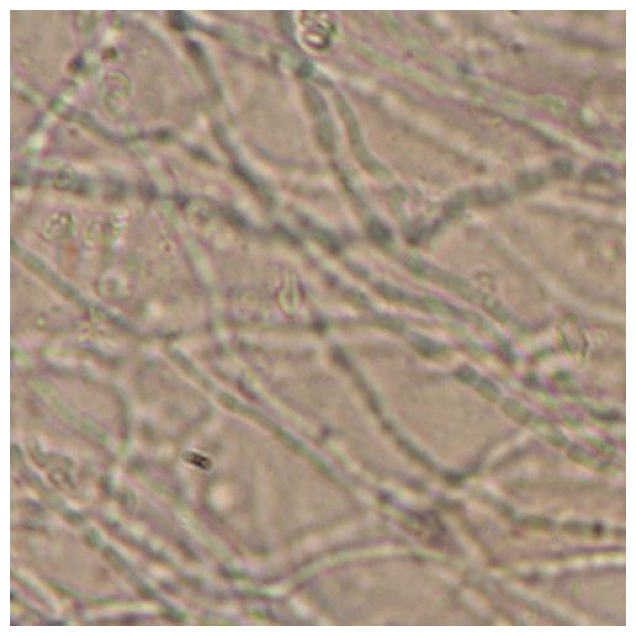

In [51]:
# idx = 0
idx = 3
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[idx].squeeze()
label = train_labels[idx]

show_img(img)


Feature batch shape: torch.Size([4, 3, 500, 500])
Labels batch shape: torch.Size([4])
Feature shape: torch.Size([3, 500, 500])
Labels shape: torch.Size([])


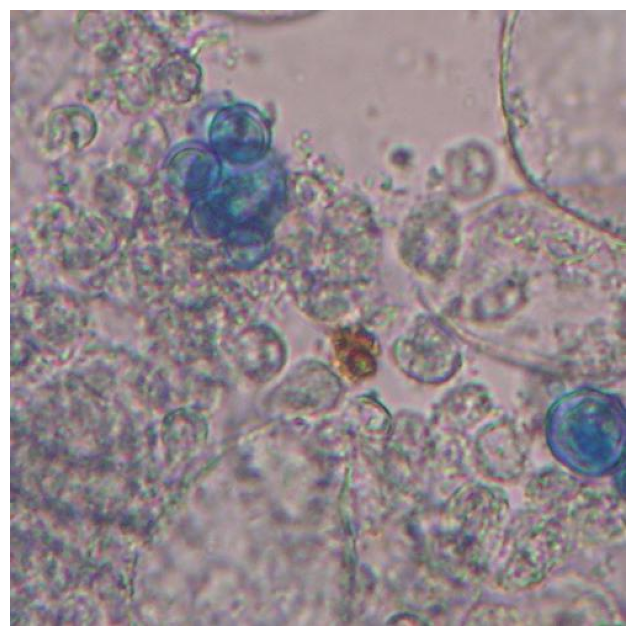

In [10]:
idx = 3
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[idx].squeeze()
label = train_labels[idx]
print(f"Feature shape: {img.size()}")
print(f"Labels shape: {label.size()}")

show_img(img)

In [11]:
cnn = ConvNet().to('cuda')

In [12]:
print(cnn)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [13]:
[param.nelement() for param in cnn.parameters()]

[216,
 8,
 1152,
 16,
 4608,
 32,
 18432,
 64,
 73728,
 128,
 147456,
 128,
 147456,
 128,
 589824,
 512,
 2560,
 5]

In [14]:
sum([param.nelement() for param in cnn.parameters()])

986453

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), 
                                                lr=0.0001, 
                                                weight_decay=0,
                                                amsgrad=False)
# optimizer = torch.optim.AdamW(cnn.parameters(), 
#                                                     lr=0.001, 
#                                                     weight_decay=0.01, 
#                                                     amsgrad=False)

In [16]:
# links: data
# linke: pytorhc.org????
# references

# device if cuda availabe

In [17]:
EPOCHS = 2

In [18]:
for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader, 0):
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        optimizer.zero_grad()

        predictions = cnn(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print every 100 mini-batches
        if not(i % 100) and i:
            print(f'EPOCH {epoch}: LOSS={running_loss/i}')


# EPOCH 0: LOSS=1.627567354440689
# EPOCH 0: LOSS=1.6194222623109817
# EPOCH 0: LOSS=1.6163778499762218
# EPOCH 0: LOSS=1.614163839817047
# EPOCH 0: LOSS=1.580512156009674
# EPOCH 0: LOSS=1.5539897662401199
# EPOCH 0: LOSS=1.524099610703332
# EPOCH 0: LOSS=1.500572560504079
# EPOCH 1: LOSS=1.3312470990419387
# EPOCH 1: LOSS=1.3028232562541961
# EPOCH 1: LOSS=1.309698739250501
# EPOCH 1: LOSS=1.305524743050337
# EPOCH 1: LOSS=1.302793959736824
# EPOCH 1: LOSS=1.2994073651234308
# EPOCH 1: LOSS=1.2930685886314937
# EPOCH 1: LOSS=1.2815951988101006

EPOCH 0: LOSS=1.627578890323639
EPOCH 0: LOSS=1.6194562083482742
EPOCH 0: LOSS=1.6163852659861246
EPOCH 0: LOSS=1.6142957371473312
EPOCH 0: LOSS=1.6031000547409058
EPOCH 0: LOSS=1.576366246143977
EPOCH 0: LOSS=1.5409805292742593
EPOCH 0: LOSS=1.5158645297586917
EPOCH 1: LOSS=1.330617059469223
EPOCH 1: LOSS=1.3007452088594436
EPOCH 1: LOSS=1.306802797317505
EPOCH 1: LOSS=1.3036507059633733
EPOCH 1: LOSS=1.2990412013530732
EPOCH 1: LOSS=1.2901422305901846
EPOCH 1: LOSS=1.274499237707683
EPOCH 1: LOSS=1.2583802120387555


In [19]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        predictions = cnn(images)
        _, predictions = torch.max(predictions.data, 1)
        
        predictions = predictions.to('cpu').detach().numpy()
        labels = labels.to('cpu').detach().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)        

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [20]:
pr = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

print(f'Precision: {pr}')
print(f'Recall: {re}')

Precision: 0.4881209460443633
Recall: 0.5122857142857142


In [21]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [22]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

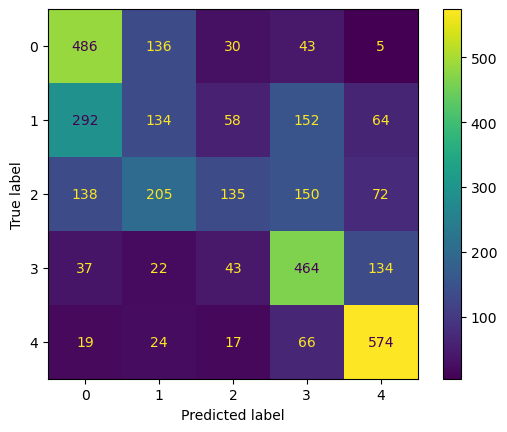

In [23]:
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

In [24]:
crep = classification_report(y_true=y_true, y_pred=y_pred)

In [25]:
print(crep)

              precision    recall  f1-score   support

           0       0.50      0.69      0.58       700
           1       0.26      0.19      0.22       700
           2       0.48      0.19      0.27       700
           3       0.53      0.66      0.59       700
           4       0.68      0.82      0.74       700

    accuracy                           0.51      3500
   macro avg       0.49      0.51      0.48      3500
weighted avg       0.49      0.51      0.48      3500



In [26]:
fake_imgfile_list = glob('../data/CIFAKE/train/FAKE/*')
real_imgfile_list = glob('../data/CIFAKE/train/REAL/*')

In [41]:
img = cv2.imread(real_imgfile_list[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB

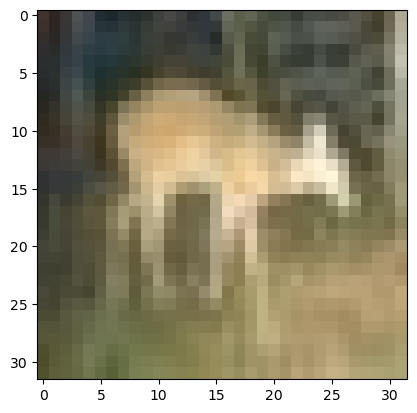

In [42]:
plt.imshow(img)
plt.show()

In [46]:
real = [cv2.imread(imgfile) for imgfile in real_imgfile_list]
fake = [cv2.imread(imgfile) for imgfile in fake_imgfile_list]

In [47]:
# np.float16
real = np.array(real)
fake = np.array(fake)


In [48]:
real.shape

(50000, 32, 32, 3)

In [49]:
fake.shape

(50000, 32, 32, 3)

In [51]:
fake.dtype

dtype('uint8')

In [52]:
real.mean(), real.min(), real.max()

(120.68823526692708, 0, 255)

In [54]:
real = real / 255
fake = fake / 255

In [55]:
real.mean(), real.min(), real.max()

(0.4732871971252034, 0.0, 1.0)

In [15]:
fungi = [
    glob(f'../data/defungi/{h}/*') for h in [
        'H1', 'H2', 'H3', 'H5', 'H6'
    ]
]

In [16]:
[len(h) for h in fungi]

[4404, 2334, 819, 818, 739]

In [17]:
fungi = [
    np.array([cv2.imread(imgfile) for imgfile in h])
    for h in fungi
]

In [18]:
[h.shape for h in fungi]

[(4404, 500, 500, 3),
 (2334, 500, 500, 3),
 (819, 500, 500, 3),
 (818, 500, 500, 3),
 (739, 500, 500, 3)]

In [19]:
fungi = [
    h[:500, :]
    for h in fungi
]

Could use albumentations to augment underrepresented classes, oversampling etc., but use undersampling (correct?) since this already takes 6.5GB as it is...

In [ ]:
fungi = [
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
]

In [20]:
4404 + 2334 + 819 + 818 + 739

9114

In [21]:
fungi = np.concatenate(fungi)

In [22]:
fungi.shape

(2500, 500, 500, 3)

In [12]:
fungi.shape

(9114, 500, 500, 3)

In [13]:
9114 * 500 * 500 * 3 / 1024**2

6518.840789794922

In [23]:
2500 * 500 * 500 * 3 / 1024**2

1788.1393432617188

In [26]:
fungi_labels = np.zeros(2500)
fungi_labels[500:1000] = 1
fungi_labels[1000:1500] = 2
fungi_labels[1500:2000] = 3
fungi_labels[2000:] = 4

In [27]:
fungi_labels.shape

(2500,)

In [ ]:
cv2.cvt_color

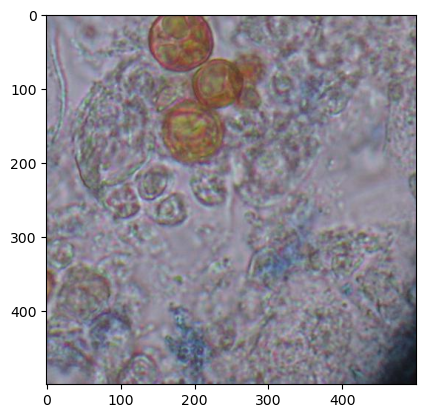

In [41]:
plt.imshow(fungi[1780])